In [1]:
from splinter import Browser
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd

In [12]:
from sklearn.preprocessing import StandardScaler

In [2]:
# Setup splinter
executable_path = {'executable_path': ChromeDriverManager().install()}
browser = Browser('chrome', **executable_path, headless=False)



====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Get LATEST driver version for 91.0.4472
Driver [C:\Users\Andrew\.wdm\drivers\chromedriver\win32\91.0.4472.101\chromedriver.exe] found in cache


In [3]:
#Page URL
url = 'https://www.trulia.com/for_sale/36.63199,38.40726,-78.77798,-76.20855_xy/9_zm/'
browser.visit(url)

In [4]:
# Initialize Lists
housePrices = []
houseRegion = []
houseSqrFt = []
houseBath = []
houseBed = []


#For each page of houses
for x in range(1, 20):
    
    print(f'Processing Page {x} - Initialize', end='\r')
    html = browser.html
    soup = BeautifulSoup(html, 'html.parser')
    
    #Data scrape from html
    prices = soup.find_all('div', {'data-testid' : "property-price"})
    beds = soup.find_all('div', {'data-testid' : "property-beds"})
    baths = soup.find_all('div', {'data-testid' : "property-baths"})
    sqrFt = soup.find_all('div', {'data-testid' : "property-floorSpace"})
    region = soup.find_all('div', {'data-testid' : "property-region"})
    print(f'Processing Page {x} - Data Scrape', end='\r')
    
    #Add scraped data to lists
    for i, price in enumerate(prices):        
        housePrices.append(price.text)
        houseBed.append(beds[i].text[0])
        houseBath.append(baths[i].text[0])
        houseSqrFt.append(sqrFt[i].text.split()[0])
        houseRegion.append(region[i].text)
    print(f'Processing Page {x} - List append', end='\r')

    #Next Page button
    browser.find_by_xpath('//*[@id="resultsColumn"]/nav/ul/li[8]/a/div/svg')
    print(f'Processing Page {x} - Next Page', end='\r')
    
    

In [5]:
# Initialize Data Frame
house_df = pd.DataFrame(
    {
        'Prices': housePrices,
        'Beds': houseBed,
        'Baths': houseBath,
        'SquareFt': houseSqrFt,
        'Loc': houseRegion
    }

)

In [6]:
#Data Conversion

try: 
    house_df.SquareFt = house_df.SquareFt.str.replace(',', '').astype(int)
except:
    print('Sqrft Data already converted.')
try:
    house_df.Beds = house_df.Beds.astype(int)
except:
    print('Bed Data already converted.')
try:
    house_df.Bath = house_df.Bath.astype(int)
except:
    print('Bath Data already converted.')

try:
    house_df.Prices = house_df.Prices.replace('[\$,]', '', regex=True).astype(float)
except:
    print('Price Data already Converted.')


Bath Data already converted.


In [7]:
house_df.dtypes

Prices      float64
Beds          int32
Baths        object
SquareFt      int32
Loc          object
dtype: object

In [13]:
features = ['Prices', 'Beds', 'Baths', 'SquareFt']

In [15]:
x = house_df.loc[:, features].values

y = house_df.loc[:,['Loc']].values

x = StandardScaler().fit_transform(x)

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principal_df = pd.DataFrame(
    data = principalComponents,
    columns = ['pc1', 'pc2']
    
)

In [48]:
finalDf = pd.concat(
    [principal_df, house_df[['Loc']]], axis = 1
)

In [49]:
finalDf

,pc1,pc2,Loc
0,-2.572385,0.346034,"North Chesterfield, VA"
1,0.873317,-0.623762,"North Chesterfield, VA"
2,0.892260,0.424370,"Midlothian, VA"
3,0.519175,0.133733,"Midlothian, VA"
4,-0.590266,-1.605438,"Charlottesville, VA"
...,...,...,...
565,-2.196126,-0.169632,"Chester, VA"
566,0.382774,0.601725,"Chester, VA"
567,-1.057402,0.283468,"Mechanicsville, VA"
568,-1.248342,0.145979,"Chesterfield, VA"


In [28]:
import matplotlib.pyplot as plt 

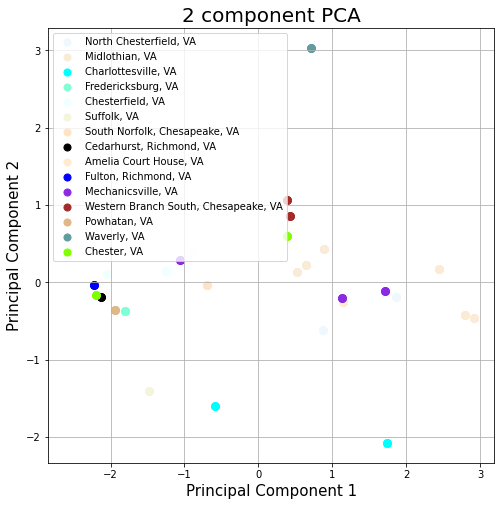

In [65]:

# Additon
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = list(pd.unique(house_df.Loc.values))
colors = list(matplotlib.colors.cnames.values())[0:16]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Loc'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [40]:
list(pd.unique(house_df.Loc.values))

['North Chesterfield, VA',
 'Midlothian, VA',
 'Charlottesville, VA',
 'Fredericksburg, VA',
 'Chesterfield, VA',
 'Suffolk, VA',
 'South Norfolk, Chesapeake, VA',
 'Cedarhurst, Richmond, VA',
 'Amelia Court House, VA',
 'Fulton, Richmond, VA',
 'Mechanicsville, VA',
 'Western Branch South, Chesapeake, VA',
 'Powhatan, VA',
 'Waverly, VA',
 'Chester, VA']

In [58]:
targets = list(pd.unique(house_df.Loc.values))
colors = ['r']*15
list(zip(targets,colors))

[('North Chesterfield, VA', 'r'),
 ('Midlothian, VA', 'r'),
 ('Charlottesville, VA', 'r'),
 ('Fredericksburg, VA', 'r'),
 ('Chesterfield, VA', 'r'),
 ('Suffolk, VA', 'r'),
 ('South Norfolk, Chesapeake, VA', 'r'),
 ('Cedarhurst, Richmond, VA', 'r'),
 ('Amelia Court House, VA', 'r'),
 ('Fulton, Richmond, VA', 'r'),
 ('Mechanicsville, VA', 'r'),
 ('Western Branch South, Chesapeake, VA', 'r'),
 ('Powhatan, VA', 'r'),
 ('Waverly, VA', 'r'),
 ('Chester, VA', 'r')]

In [64]:
import matplotlib
list(matplotlib.colors.cnames.values())[0:16]

['#F0F8FF',
 '#FAEBD7',
 '#00FFFF',
 '#7FFFD4',
 '#F0FFFF',
 '#F5F5DC',
 '#FFE4C4',
 '#000000',
 '#FFEBCD',
 '#0000FF',
 '#8A2BE2',
 '#A52A2A',
 '#DEB887',
 '#5F9EA0',
 '#7FFF00',
 '#D2691E']